# Total variation in-painting

## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

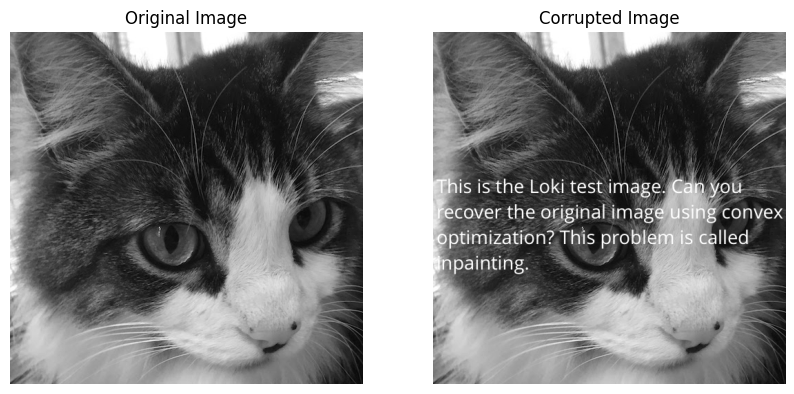

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
u_orig = plt.imread("/Users/minseoksong/Downloads/loki512.png")
u_corr = plt.imread("/Users/minseoksong/Downloads/loki512_corrupted.png")
rows, cols = u_orig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if u_orig[i, j] == u_corr[i, j]:
            known[i, j] = 1

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

The total variation in-painting problem can be easily expressed in CVXPY. We use the solver SCS, which scales to larger problems than ECOS does.

1) sum of squares

In [104]:
import cvxpy as cp

X = cp.Variable(np.sum(known == 0))
K_variable = cp.Variable(shape = u_orig.shape)
K = np.array(known * u_orig)
zero_indices = np.where(known == 0)
non_zero_indices = np.where(known == 1)
objective = cp.Minimize(cp.sum_squares(K_variable[:, 1:] - K_variable[:, :-1]) + cp.sum_squares(K_variable[1:, :] - K_variable[:-1, :]))
constraints = [X == K_variable[zero_indices], K_variable[non_zero_indices] == K[non_zero_indices]]
problem = cp.Problem(objective, constraints)
problem.solve()

1080.0797805919128

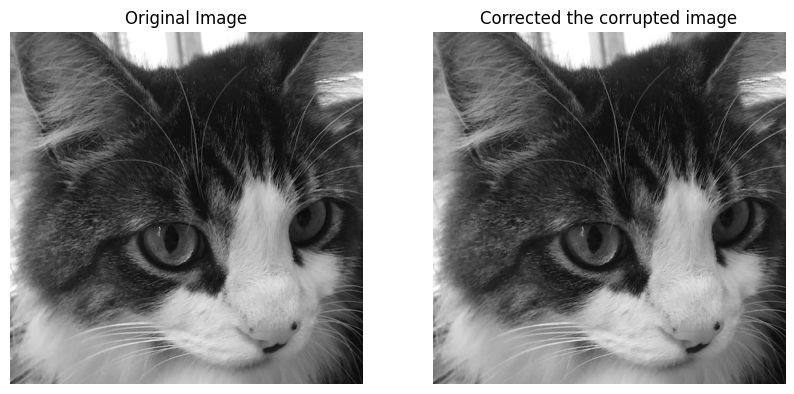

In [105]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(K_variable.value, cmap='gray');
ax[1].set_title("Corrected the corrupted image")
ax[1].axis('off');

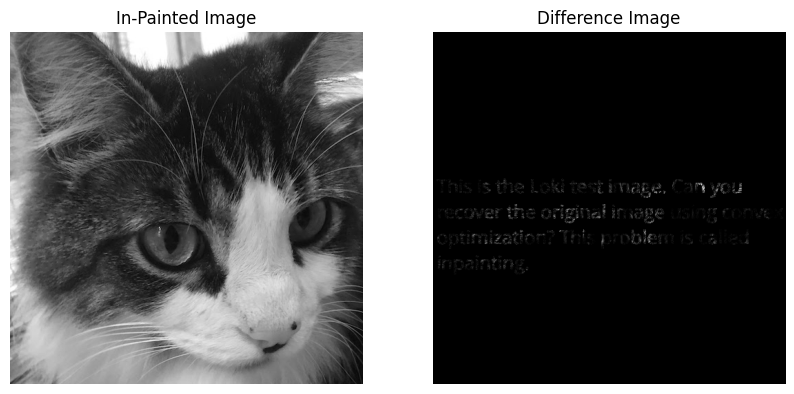

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
ax[0].imshow(K_variable.value, cmap='gray');
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = 10*np.abs(u_orig - K_variable.value)
ax[1].imshow(img_diff, cmap='gray');
ax[1].set_title("Difference Image")
ax[1].axis('off');

2) sum of absolute values

In [107]:
import cvxpy as cp

X = cp.Variable(np.sum(known == 0))
K_variable = cp.Variable(shape = u_orig.shape)
K = np.array(known * u_orig)
zero_indices = np.where(known == 0)
non_zero_indices = np.where(known == 1)
objective = cp.Minimize(cp.sum(cp.abs((K_variable)[:, 1:] - K_variable[:, :-1])) + cp.sum(cp.abs(K_variable)[1:, :] - K_variable[:-1, :]))
constraints = [X == K_variable[zero_indices], K_variable[non_zero_indices] == K[non_zero_indices]]
problem = cp.Problem(objective, constraints)
problem.solve()

6513.0079596637315

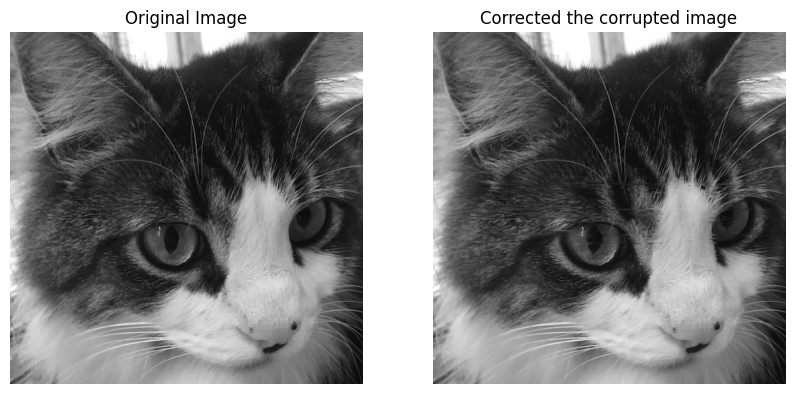

In [108]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(K_variable.value, cmap='gray');
ax[1].set_title("Corrected the corrupted image")
ax[1].axis('off');

After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

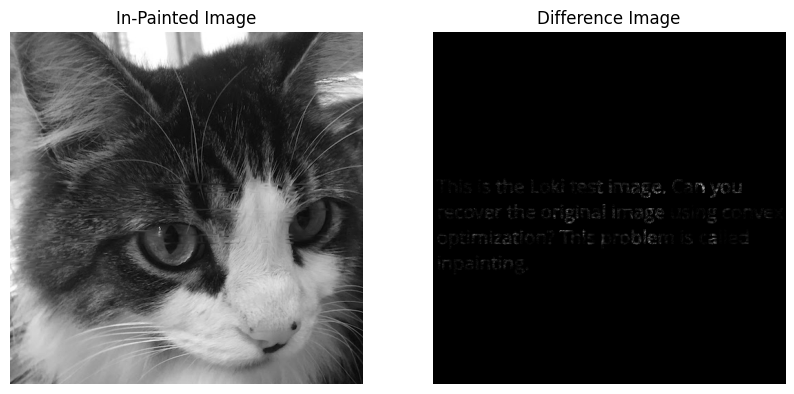

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
ax[0].imshow(K_variable.value, cmap='gray');
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = 10*np.abs(u_orig - K_variable.value)
ax[1].imshow(img_diff, cmap='gray');
ax[1].set_title("Difference Image")
ax[1].axis('off');